In [19]:
!pip install mrcnn

In [0]:
import os
from pathlib import Path
import cv2
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN
import numpy as np
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
#import flask
#from flask import  Flask,render_template,request

In [0]:
# app = Flask(__name__)

In [0]:
# @app.route('/')
# @app.route('/index')
# def index():
#   return flask.render_template('index.html')

In [0]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

In [0]:
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  # COCO dataset has 80 classes + one background class
    DETECTION_MIN_CONFIDENCE = 0.6

In [0]:
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck or bus then skip it
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

In [0]:
Root_Dir = Path(".")  


Model_Dir = os.path.join(Root_Dir, "logs")

# Local path to trained weights file
Coco_Model_Path = os.path.join(Root_Dir, "mask_rcnn_coco.h5")

# Download COCO trained weights
if not os.path.exists(Coco_Model_Path):
    mrcnn.utils.download_trained_weights(Coco_Model_Path)

# Directory of images to run detection on / These images are created during the creation of frames
IMAGE_DIR = os.path.join(Root_Dir, "images")

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
dir

<function dir>

In [29]:
!dir

1_pLdJRvle28NOboyLHMlM8A.gif
Car\ in\ Parking\ Garage\ -\ Security\ Camera.mp4
drive
index.html
logs
mask_rcnn_coco.h5
sample_data
tpu
vlc-record-2019-10-02-14h42m02s-Metrici\ Parking\ Place\ Detector-\ Live\ view\ timelapse.mp4-.mp4
vlc-record-2019-10-02-15h32m25s-videoplayback.mp4-.mp4


In [0]:
Video = "1_pLdJRvle28NOboyLHMlM8A.gif"

In [0]:

model = MaskRCNN(mode="inference", model_dir=Model_Dir, config=MaskRCNNConfig())

In [0]:
model.load_weights(Coco_Model_Path, by_name=True)


In [0]:
parked_car_boxes = None

In [0]:
video_capture = cv2.VideoCapture(Video)

In [0]:
from google.colab.patches import cv2_imshow

Space Unavailable


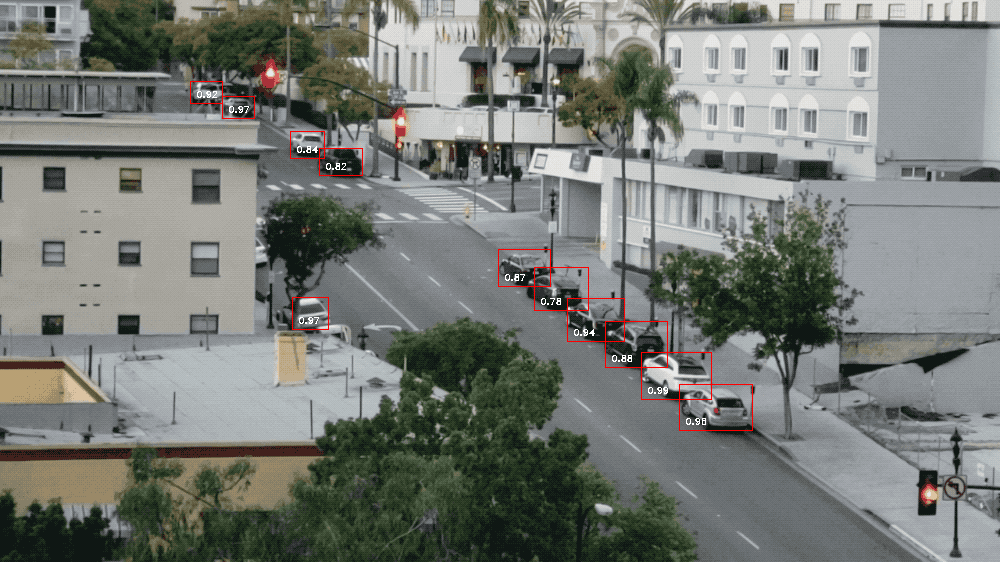

Space Unavailable


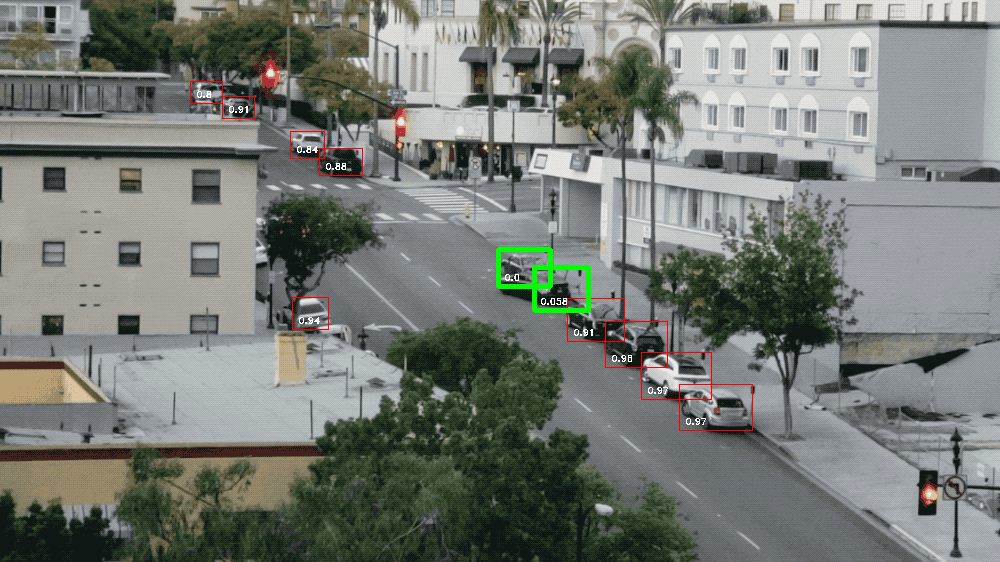

Space Unavailable


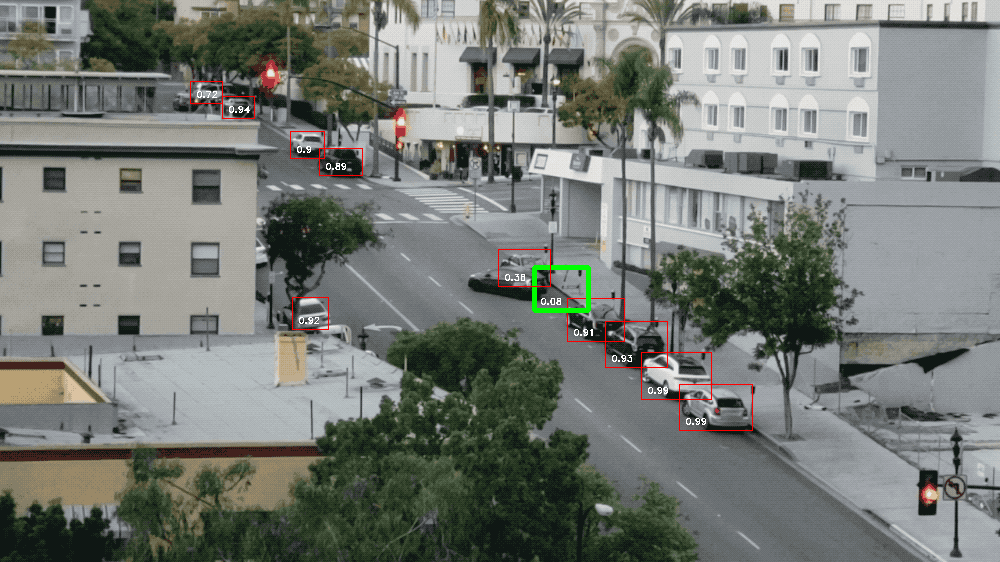

Space Unavailable


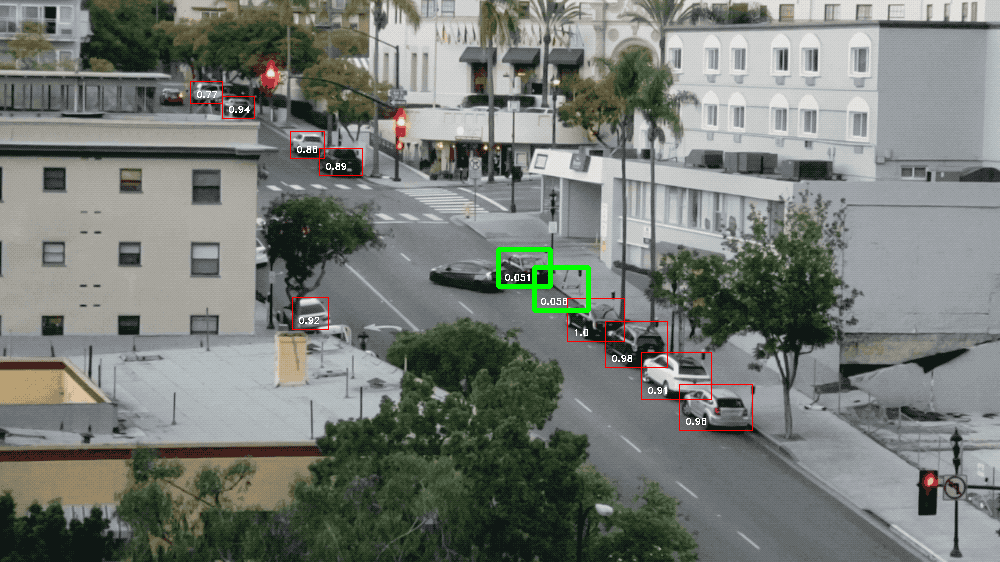

In [36]:
  while video_capture.isOpened():
    success, frame = video_capture.read()
    #frame.set(cv2.CAP_PROP_FPS, 20)
    if not success:
        break

    # BGR -> RGB
    rgb_image = frame[:, :, ::-1]

    # Run the image through the Mask R-CNN model to get results.
    results = model.detect([rgb_image], verbose=0)

    r = results[0]


    if parked_car_boxes is None:
        
        parked_car_boxes = get_car_boxes(r['rois'], r['class_ids'])
    else:
       

        # Get where cars are currently located in the frame
        car_boxes = get_car_boxes(r['rois'], r['class_ids'])

        # those cars which overlap with the known parking spaces
        overlaps = mrcnn.utils.compute_overlaps(parked_car_boxes, car_boxes)

       
        free_space = False


        for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):

   
            max_IoU_overlap = np.max(overlap_areas)

            
            y1, x1, y2, x2 = parking_area

           
            if max_IoU_overlap < 0.10:
                # Parking space not occupied! Draw a green box around it
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                # Flag that we have seen at least one open space
                free_space = True
            else:
                # Parking space is still occupied - draw a red box around it
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)

            
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"{max_IoU_overlap:0.2}", (x1 + 6, y2 - 6), font, 0.3, (255, 255, 255))

        # If at least one space was free, start counting frames
        # This is so we don't alert based on one frame of a spot being open.
        # This helps prevent the script triggered on one bad detection.
        if free_space:
            free_space_frames += 1
        else:
            # If no spots are free, reset the count
            free_space_frames = 0

        # If a space has been free for several frames,then space is available
        if free_space_frames > 10:
            #prediction=1
            print("Space available!")
        else:
            #prediction=0
            print('Space Unavailable')
        
        cv2_imshow(frame)

    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    #return render_template("index.html",prediction=prediction)

video_capture.release()
cv2.destroyAllWindows()


